# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2024-2025, Q4
* Course homepage: https://brightspace.tudelft.nl/d2l/home/682445
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Niels Stienen (N.L.Stienen@student.tudelft.nl)
* (c) TU Delft, 2025

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please **do not** delete it, instead run that cell as you would run all other cells. Finally, please **do not** add any extra cells to this notebook or change the existing cells unless you are explicitly asked to do so.

Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Nicola Visentin"
STUDENT_1_STUDENT_NUMBER = "6354815"
STUDENT_1_NETID = "nvisentin"
STUDENT_1_EMAIL = "N.Visentin@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. Please note that it is **not** allowed to post any code relating to solution attempts. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA or if not possible otherwise, send an email to the instructor or TA.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. 

* Please note that the above mentioned _read-only_ protection only works in Jupyter Notebook, and it does not work if you open this notebook in another editor (e.g., VSCode, PyCharm, etc.). Therefore, we recommend that you only use Jupyter Notebook for this course. If you use any other editor, you may accidentally delete cells, modify the tests, etc., which would cause you to lose points.

* If you edit a function that is imported in another notebook, you need to **restart the kernel** of the notebook where you are using the function. Otherwise, the changes will not be effective.

* **IMPORTANT**: Please make sure that your code executes without any errors before submitting the notebook. An easy way to ensure this is to use the validation script as described in the README.

# Task 3a - Gaussian Process Regression (6p)
**Authors:** Giovanni Franzese, Lorenzo Lyons (L.Lyons@tudelft.nl)

## Cheat sheet for Gaussian Process Regression (GPR) using the `gpytorch` library.
Zero mean 

```python
        gpytorch.means.ZeroMean()
```

Constant mean

```python
        gpytorch.means.ConstantMean()
```

RBF kernel

```python
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
```

Matern kernel

```python
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
```

RBF with ARD

```python
        gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=n)) # where n is the number of features of the inptus
```

Gaussian likelihood 
        
```python
        gpytorch.likelihoods.GaussianLikelihood()
```

Maximum Likelihood Estimation (MLE) 

```python
        gpytorch.mlls.ExactMarginalLogLikelihood()
```

Makine prediction with Gaussian Process p(f*|x*,X,Y)

```python
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = model(test_x)
            mean = predictions.mean
            lower, upper = predictions.confidence_region()
            std = predictions.stddev
            var = predictions.variance
```

Makine prediction with Gaussian Process p(y*|x*,X,Y)

```python
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = likelihood(model(test_x))
```

```python
   
```
Print the learned horizontal lenghtscales
        
```python
        model.covar_module.base_kernel.lengthscale
```

Print the learned vertical lenghtscales
        
```python
        model.covar_module.raw_outputscale
```

Print the learned noise
        
```python
        model.likelihood.noise
```



## Load the tensile analysis sample dataset

In [3]:
# load panda framework from txt file the first row is the header
# Dataset from: https://mtil.illinois.edu/DATA/_DataAnalysisHELP/_Tensile_Example/Tensile_Analysis/6150_Tensile_Data/
import pandas as pd
from pathlib import Path

steel = pd.read_csv(Path("datasets") / "tensile_strenght.txt", sep="\t", header=1)
steel.head()

,Position(mm),Load(kN),Strain(-/-),Time(sec)
0,0.00,0.0859,0.000054,0
1,0.03,0.2550,0.000054,1
2,0.07,0.2820,0.000054,2
3,0.10,0.2950,0.000054,3
4,0.13,0.3090,0.000054,4


In [4]:
X = steel["Position(mm)"].to_numpy()[:-1]
Y = steel["Load(kN)"].to_numpy()[:-1]

Text(0, 0.5, 'Load(kN)')

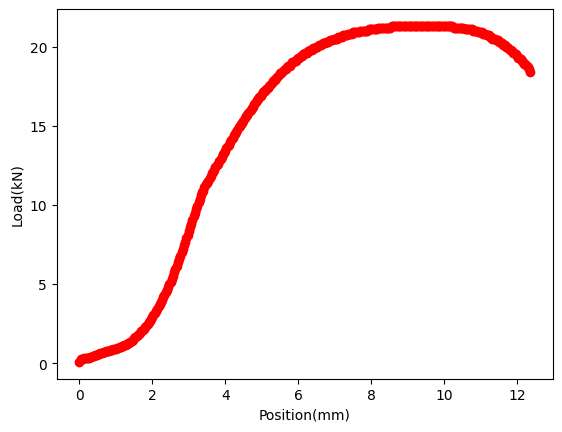

In [5]:
from matplotlib import pyplot as plt

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

plt.plot(X, Y, "o", color="red")
plt.xlabel("Position(mm)")
plt.ylabel("Load(kN)")

## Task 3a.1 - Fit the data with an Exact Gaussian Process (2.5p)

### Definition of the model class (1p)
Define the Exact Gaussian Process Model with a zero mean and RBF kernel.

In [6]:
import gpytorch
import numpy as np
import torch
from tqdm.notebook import tqdm  # progress bar

# Class for exact GP: forward method gives back a multivariate Gaussian distribution N(mean_x,covar_x).
# self.mean_module is initialized to zero mean (we assume a priori mean of f = 0): we expect the mean of the 
# prediction to fall back to zero out of the dataset. We choose a simple RBF kernel.

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Use zero mean and covariance modules as the rbf kernel
        # self.mean_module
        # self.covar_module
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


### Train the model (1p)
Define the likelihood to be Gaussian, the model to be the Exact GP defined in the previous step, and the Marginal log-likelihood as a cost function to optimize the kernel function's hyperparameters.

In [7]:
# set random seed
torch.manual_seed(42)

train_x = torch.tensor(X)
train_y = torch.tensor(Y)

# initialize likelihood and model
exact_likelihood = gpytorch.likelihoods.GaussianLikelihood()
exact_model = ExactGPModel(train_x, train_y, exact_likelihood)

# Find optimal model hyperparameters
exact_model.train()
exact_likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(
    exact_model.parameters(), lr=0.1
)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
marginal_mll = gpytorch.mlls.ExactMarginalLogLikelihood(exact_likelihood, exact_model)

num_epochs = 500
for i in (pbar := tqdm(range(num_epochs))):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = exact_model(train_x)
    # Calc loss and backprop gradients
    # we minimize the negaitive log likelihood that is the same as maximizing the log likelihood
    loss = -marginal_mll(output, train_y)
    loss.backward()
    optimizer.step()

    pbar.set_description(
        "Loss: %.3f, lengthscale: %.3f, noise: %.3f"
        % (
            loss.item(),
            exact_model.covar_module.base_kernel.lengthscale.item(),
            exact_model.likelihood.noise.item(),
        )
    )

  0%|          | 0/500 [00:00<?, ?it/s]

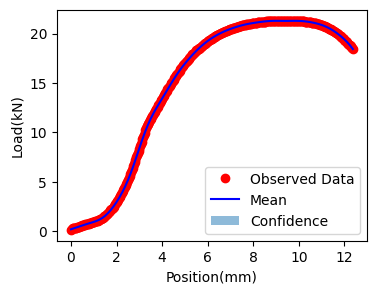

In [8]:
# Get into evaluation (predictive posterior) mode
exact_model.eval()
exact_likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(torch.min(train_x), torch.max(train_x), 100).double()
    observed_pred = exact_likelihood(exact_model(test_x))

with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    plt.xlabel("Position(mm)")
    plt.ylabel("Load(kN)")
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), "ro")
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), "b")
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(["Observed Data", "Mean", "Confidence"])
    fig.savefig(outputs_dir / "task_3a-1_load_vs_position.pdf")

### Extraction of the length scales and the likelihood noise (0.5p)
Print the horizontal and vertical length scales and the likelihood noise

In [9]:
from IPython.display import display, Math

l = exact_model.covar_module.base_kernel.lengthscale.item()
sigma_f_2 = exact_model.covar_module.raw_outputscale.item()
sigma_n_2 = exact_model.likelihood.noise.item()

display(Math(f"\\text{{Horizontal lengthscale: }} l = {l}"))
display(Math(f"\\text{{Vertical scale: }} \\sigma_f^2 = {sigma_f_2}"))
display(Math(f"\\text{{Likelihood noise: }} \\sigma_n^2 = {sigma_n_2}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Task 3a.2 - Fit the curve using only a reduced set of inducing points using Sparse Variational Gaussian Process (3.5p)
The Stochastic Variational Gaussian Process (SVGP) is a sparse approximation of the Exact GP. The SVGP model is defined by selecting a set of inducing points and optimizing the hyperparameters of the kernel function and the inducing points. The structure of the model is similar to an exact GP but has additional variables that are optimized during training, i.e., the inducing points, and the cost function is the Evidence Lower Bound (ELBO) instead of the Marginal log-likelihood.

### Cheat sheet for Sparse Variational Gaussian Process (SVGP) (0p)
Gaussian likelihood 

Expected Variational lower bound of the maximum likelihood to use as an alternative to the MLE

```python
        elbo_mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))
```
where the train_y.size(0) is the number of training samples; this number is used to scale the ELBO to the same scale as the MLE.

Print the learned inducting points:
        
```python
        model.variational_strategy.inducing_points
```

The likelihood and the kernel are the same as the exact GP model.

Choose the model to be an SVGP model where you select 10 inducing points equally spaced along the x-axis.  (3p)

### Define the `SVGPModel` (0.5p)
Choose the mean and the kernel in the definition of the model as in the previous task, i.e., zero mean and RBF kernel (0.5p).

In [10]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

# set random seed
torch.manual_seed(42)


class SVGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super(SVGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


### Select inducing points (1p)
Choose ten inducing points equally spaced along the x-axis, initialize the model as an SVGP as defined above, and choose the likelihood to be Gaussian.

In [11]:
# Define inducing points: it's a (N_ind,D) tensor, where D is the number of features (in our case x is only position) 
inducing_points = torch.linspace(torch.min(train_x), torch.max(train_x), 10)
inducing_points = inducing_points.unsqueeze(-1)  # from (10,) to (10,1)

# initialize model and likelihood
svgp_model = SVGPModel(inducing_points)
svgp_likelihood = gpytorch.likelihoods.GaussianLikelihood()

svgp_model = svgp_model.double()
svgp_likelihood = svgp_likelihood.double()

### Train the model (0.5p)
Define the cost function as ELBO.

In [12]:
from torch.utils.data import TensorDataset, DataLoader

svgp_model.train()
svgp_likelihood.train()

optimizer = torch.optim.Adam(
    [
        {"params": svgp_model.parameters()},
        {"params": svgp_likelihood.parameters()},
    ],
    lr=0.01,
)


# Our loss object. We're using the VariationalELBO rather than the ExactMarginalLogLikelihood.
elbo_mll = gpytorch.mlls.VariationalELBO(svgp_likelihood, svgp_model, num_data=train_y.size(0))

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

num_epochs = 10000
for i in tqdm(range(num_epochs)):
    # Within each iteration, we will go over each minibatch of data
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = svgp_model(x_batch)
        loss = -elbo_mll(output, y_batch)
        loss.backward()
        optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

### Test the trained model (1p)
Define the test points as 100 equally spaced points between 0 and max of the training data. Then, evaluate p(y*|x*,X,Y) for the test points. Finally, save the optimized inducing points in a new vector.

In [13]:
# Get into evaluation (predictive posterior) mode
svgp_model.eval()
svgp_likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, torch.max(train_x), 100).double()
    observed_pred = svgp_likelihood(svgp_model(test_x))
    inducing_inputs = svgp_model.variational_strategy.inducing_points

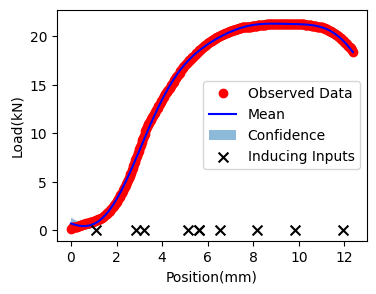

In [14]:
with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    plt.xlabel("Position(mm)")
    plt.ylabel("Load(kN)")
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), "ro")
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), "b")
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.scatter(
        inducing_inputs.numpy(),
        np.zeros_like(inducing_inputs.numpy()),
        color="k",
        marker="x",
        s=50,
        zorder=10,
        label="Inducing Inputs",
    )
    ax.legend(["Observed Data", "Mean", "Confidence", "Inducing Inputs"])
    fig.savefig(outputs_dir / "task_3a-2_load_vs_position.pdf")

### Extraction of the length scales and the likelihood noise (0.5p)
Print the the horizontal and vertical lengthscale and the noise of the learned model.

In [15]:
l_svgp = svgp_model.covar_module.base_kernel.lengthscale.item()
sigma_f_2_svgp = svgp_model.covar_module.raw_outputscale.item()
sigma_n_2_svgp = svgp_likelihood.noise.item()

display(Math(f"\\text{{Horizontal lengthscale: }} l = {l_svgp}"))
display(Math(f"\\text{{Vertical scale: }} \\sigma_f^2 = {sigma_f_2_svgp}"))
display(Math(f"\\text{{Likelihood noise: }} \\sigma_n^2 = {sigma_n_2_svgp}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>